In [3]:
##DECOMPOSITION of video frames 14/03/2021
import sys
import shutil

import numpy as np
from math import floor
import pandas as pd
import numpy as np
import cv2

import os
import time
from PIL import Image
import math

# command line arguments --> file name, video_file_name, gpu or cpu 


# first decompose the video to frames
# place the video to be detected into the directory


#video = sys.argv[1]
#pred_text_file_name = sys.argv[2]

# resize image
#output = cv2.resize(src, dsize)


start = time.time()
text_file = 'frames.txt'

print('decomposing video to frames this may take a while  for large videos :) .....')
frames_path = 'video_frames/'
os.makedirs('video_frames/', exist_ok=True)
#os.makedirs('predictions/', exist_ok=True)

f = open(text_file, 'w+')
# Opens the Video file
cap= cv2.VideoCapture('/content/anni009.mpg')
i=1
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    scale_percent = 25

#calculate the 50 percent of original dimensions
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)

# dsize
    dsize = (width, height)

    output = cv2.resize(frame, dsize) 
    frame_path = frames_path + 'frame_' + str(i) + '.jpg'
    cv2.imwrite("/content/video_frames/frame_"+ str(i) + ".jpg", output)
    f.write(frame_path + '\n')
    i+=1

cap.release()
cv2.destroyAllWindows()
print("decomposition complete")

end = time.time()
# total time taken
print(f"Runtime of the program is {end - start}")

decomposing video to frames this may take a while  for large videos :) .....
decomposition complete
Runtime of the program is 9.6640043258667


In [4]:
#EXTRACTING GROUNDTRUTH FROM XML FILE FOR ABRUPT CUT
import numpy as np
import xml.etree.ElementTree as ET
mytree = ET.parse('/content/ref_anni009.xml')
myroot = mytree.getroot()
print(int(myroot.attrib.get('totalFNum')))
totfno = int(myroot.attrib.get('totalFNum'))
prefno = []
postno = []
pref = []
postf = []
classi1 = []
cl = []
for x in myroot.findall('trans'):
  it1 = x.attrib.get('preFNum')

  it2 = x.attrib.get('postFNum')
  item =x.attrib.get('type')
  #print(item)
  prefno.append(int(it1))
  postno.append(int(it2))
  pref.append("frame%d.jpg" % int(it1))
  postf.append("frame%d.jpg" % int(it2))
  classi1.append(item)
  pre11 = []
  post11 = []
for i in range(len(classi1)):
  if (classi1[i]=='CUT'):
    pre11.append(prefno[i])
    post11.append(postno[i])

#cl1 = np.array(cl)
pre1 = np.array(pre11)
post1 = np.array(post11)

feat1 = np.stack((pre1, post1), axis = 1)
print(feat1)
print(len(feat1))

np.savetxt('/content/ab_cut_gt.txt', post1, fmt='%s', delimiter=' ')


12307
[[ 146  147]
 [1921 1922]
 [2268 2269]
 [2440 2441]
 [2474 2475]
 [2492 2493]
 [2552 2553]
 [2604 2605]
 [2658 2659]
 [2712 2713]
 [2763 2764]
 [2819 2820]
 [2886 2887]
 [4055 4056]
 [4108 4109]
 [4227 4228]
 [4327 4328]
 [4715 4716]
 [5996 5997]
 [6134 6135]
 [6519 6520]
 [6684 6685]
 [6746 6747]
 [7062 7063]
 [7122 7123]
 [7140 7141]
 [7158 7159]
 [7177 7178]
 [7197 7198]
 [7218 7219]
 [7238 7239]
 [7255 7256]
 [8217 8218]
 [8290 8291]
 [8322 8323]
 [9160 9161]
 [9241 9242]
 [9365 9366]]
38


In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12306):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

#print(np.mean(L1))
#print(a1)
  diff = 0
  for i in range(0,Lab1.shape[0]):
    for j in range(0,Lab1.shape[1]):
      diff = diff + CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j]))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
deli = 0.22
const1 = 1   #nad57 = 139, anni09 = 1       
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+ const1)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

print("F1 Score")
print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




Streaming output truncated to the last 5000 lines.
11055
11056
0.12829754074956284
(60, 80, 3)
11056
11057
0.15964682093553423
(60, 80, 3)
11057
11058
0.15416630957094385
(60, 80, 3)
11058
11059
0.16963183129671608
(60, 80, 3)
11059
11060
0.3239201074790676
(60, 80, 3)
11060
11061
0.15295243964033978
(60, 80, 3)
11061
11062
0.33745798105365393
(60, 80, 3)
11062
11063
0.23091053771532843
(60, 80, 3)
11063
11064
0.19148920060067928
(60, 80, 3)
11064
11065
0.12629225117567636
(60, 80, 3)
11065
11066
0.12461084053907506
(60, 80, 3)
11066
11067
0.12362827085433666
(60, 80, 3)
11067
11068
0.1234862698434899
(60, 80, 3)
11068
11069
0.12461960324849941
(60, 80, 3)
11069
11070
0.165054911129922
(60, 80, 3)
11070
11071
0.1311991253700213
(60, 80, 3)
11071
11072
0.12517905243157101
(60, 80, 3)
11072
11073
0.20233565526533323
(60, 80, 3)
11073
11074
0.11966415562886118
(60, 80, 3)
11074
11075
0.20990360656783463
(60, 80, 3)
11075
11076
0.12094074846488512
(60, 80, 3)
11076
11077
0.1579922447325411

No handles with labels found to put in legend.


12305
12306
0.28950593454498846
1.0
[0.02346155 0.0209511  0.02051029 ... 0.01458394 0.0155218  0.01390472]
33
[147, 1922, 2269, 2441, 2475, 2493, 2553, 2605, 2659, 2713, 2764, 2820, 4109, 4228, 4328, 6135, 6520, 6685, 6747, 7063, 7123, 7141, 7159, 7178, 7198, 7219, 7256, 8218, 8291, 8323, 9161, 9242, 9366]
[ 147 1922 2269 2441 2475 2493 2553 2605 2659 2713 2764 2820 4109 4228
 4328 6135 6520 6685 6747 7063 7123 7141 7159 7178 7198 7219 7256 8218
 8291 8323 9161 9242 9366]
['147', '1922', '2269', '2441', '2475', '2493', '2553', '2605', '2659', '2713', '2764', '2820', '2887', '4056', '4109', '4228', '4328', '4716', '5997', '6135', '6520', '6685', '6747', '7063', '7123', '7141', '7159', '7178', '7198', '7219', '7239', '7256', '8218', '8291', '8323', '9161', '9242', '9366']
38
147
[147, 1922, 2269, 2441, 2475, 2493, 2553, 2605, 2659, 2713, 2764, 2820, 2887, 4056, 4109, 4228, 4328, 4716, 5997, 6135, 6520, 6685, 6747, 7063, 7123, 7141, 7159, 7178, 7198, 7219, 7239, 7256, 8218, 8291, 8323, 9

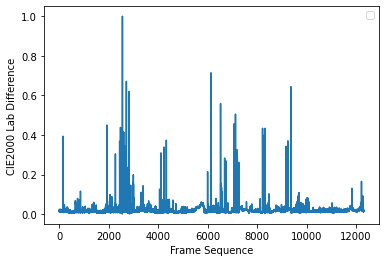

In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER with only L value
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12306):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

#print(np.mean(L1))
#print(a1)
  diff = 0
  for i in range(0,Lab1.shape[0]):
    for j in range(0,Lab1.shape[1]):
      diff = diff + CIEDE2000((L1[i][j], 0, 0), (L2[i][j], 0, 0))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
deli = 0.22
const1 = 1   #nad57 = 139, anni09 = 1       
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+ const1)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

print("F1 Score")
print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




In [ ]:
ab_cut = []
deli = 0.228
const1 = 1   #nad57 = 139, anni09 = 1       
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+ const1)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

print("F1 Score")
print(F1)



33
[147, 1922, 2269, 2441, 2475, 2493, 2553, 2605, 2659, 2713, 2764, 2820, 4109, 4228, 4328, 6135, 6520, 6685, 6747, 7063, 7123, 7141, 7159, 7178, 7198, 7219, 7256, 8218, 8291, 8323, 9161, 9242, 9366]
[ 147 1922 2269 2441 2475 2493 2553 2605 2659 2713 2764 2820 4109 4228
 4328 6135 6520 6685 6747 7063 7123 7141 7159 7178 7198 7219 7256 8218
 8291 8323 9161 9242 9366]
['147', '1922', '2269', '2441', '2475', '2493', '2553', '2605', '2659', '2713', '2764', '2820', '2887', '4056', '4109', '4228', '4328', '4716', '5997', '6135', '6520', '6685', '6747', '7063', '7123', '7141', '7159', '7178', '7198', '7219', '7239', '7256', '8218', '8291', '8323', '9161', '9242', '9366']
38
147
[147, 1922, 2269, 2441, 2475, 2493, 2553, 2605, 2659, 2713, 2764, 2820, 2887, 4056, 4109, 4228, 4328, 4716, 5997, 6135, 6520, 6685, 6747, 7063, 7123, 7141, 7159, 7178, 7198, 7219, 7239, 7256, 8218, 8291, 8323, 9161, 9242, 9366]
RECALL
0.9295774647887324
PRECISION
1.0
F1 Score
0.9635036496350364


In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER just till graph
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12306):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

#print(np.mean(L1))
#print(a1)
  diff = 0
  for i in range(0,Lab1.shape[0]):
    for j in range(0,Lab1.shape[1]):
      diff = diff + CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j]))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)



In [ ]:
#getting abrupt cuts
ab_cut = []
deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+1)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)


In [ ]:
#PRECISION RECALL SEPARATE
sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

print("F1 Score")
print(F1)


In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER WITH only MEAN as feature
#NAD58 
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12306):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

  L1m = np.mean(L1)
  a1m = np.mean(a1)
  b1m = np.mean(b1)

  L2m = np.mean(L2)
  a2m = np.mean(a2)
  b2m = np.mean(b2)

#print(np.mean(L1))
#print(a1)
  
  diff = CIEDE2000((L1m, a1m, b1m), (L2m, a2m, b2m))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+1)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

#F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

#print("F1 Score")
#print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER WITH only Standard Deviation as feature
#NAD58 
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12306):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

  L1m = np.std(L1)
  a1m = np.std(a1)
  b1m = np.std(b1)

  L2m = np.std(L2)
  a2m = np.std(a2)
  b2m = np.std(b2)

#print(np.mean(L1))
#print(a1)
  
  diff = CIEDE2000((L1m, a1m, b1m), (L2m, a2m, b2m))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+1)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

#F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

#print("F1 Score")
#print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




Streaming output truncated to the last 5000 lines.
10998
10999
6.991378838917478e-05
(60, 80, 3)
10999
11000
0.00016813851030389
(60, 80, 3)
11000
11001
4.984434966717029e-05
(60, 80, 3)
11001
11002
5.5298306525965924e-05
(60, 80, 3)
11002
11003
7.154349506303499e-05
(60, 80, 3)
11003
11004
6.77048236010365e-05
(60, 80, 3)
11004
11005
0.00010675522048096593
(60, 80, 3)
11005
11006
3.992349826360417e-05
(60, 80, 3)
11006
11007
0.00010722212875621188
(60, 80, 3)
11007
11008
7.4908832692155e-05
(60, 80, 3)
11008
11009
8.995230085778174e-05
(60, 80, 3)
11009
11010
0.00011839723181210709
(60, 80, 3)
11010
11011
0.00013939377128848346
(60, 80, 3)
11011
11012
0.00011435890778881031
(60, 80, 3)
11012
11013
0.00012712493798759796
(60, 80, 3)
11013
11014
0.00021883496498554544
(60, 80, 3)
11014
11015
0.00017096842721682232
(60, 80, 3)
11015
11016
0.00018080593034935488
(60, 80, 3)
11016
11017
0.00017928722756948664
(60, 80, 3)
11017
11018
0.0002376493469229374
(60, 80, 3)
11018
11019
0.000228566

No handles with labels found to put in legend.


12248
12249
0.000222842115077381
(60, 80, 3)
12249
12250
4.513297065068823e-05
(60, 80, 3)
12250
12251
0.00010546383797089072
(60, 80, 3)
12251
12252
1.3351165551377836e-05
(60, 80, 3)
12252
12253
5.171632785532815e-05
(60, 80, 3)
12253
12254
0.0001685456541801478
(60, 80, 3)
12254
12255
0.00015777275959310305
(60, 80, 3)
12255
12256
5.6832183302737335e-05
(60, 80, 3)
12256
12257
0.0001570614058239366
(60, 80, 3)
12257
12258
0.0003271956033109902
(60, 80, 3)
12258
12259
0.0007018431675185888
(60, 80, 3)
12259
12260
0.0006178698641715256
(60, 80, 3)
12260
12261
0.000617473351375376
(60, 80, 3)
12261
12262
0.0005202556955349888
(60, 80, 3)
12262
12263
0.000513602958259
(60, 80, 3)
12263
12264
0.0007390539025889997
(60, 80, 3)
12264
12265
0.0007586985758750018
(60, 80, 3)
12265
12266
0.0005429981597744519
(60, 80, 3)
12266
12267
0.0003665576370977441
(60, 80, 3)
12267
12268
0.00010005550658114172
(60, 80, 3)
12268
12269
0.0003469477791406027
(60, 80, 3)
12269
12270
0.0002779190683996294
(

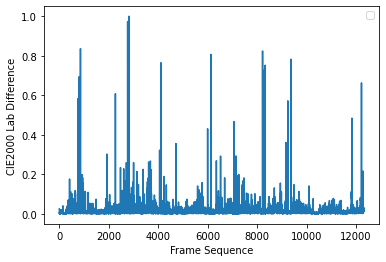

In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER WITH only variance as feature
#NAD58 
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12306):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

  L1m = np.var(L1)
  a1m = np.var(a1)
  b1m = np.var(b1)

  L2m = np.var(L2)
  a2m = np.var(a2)
  b2m = np.var(b2)

#print(np.mean(L1))
#print(a1)
  
  diff = CIEDE2000((L1m, a1m, b1m), (L2m, a2m, b2m))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+1)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

#F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

#print("F1 Score")
#print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER  both mean and standard deviation as feature
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib import*
import matplotlib.pyplot as plt
from matplotlib.cm import register_cmap
from scipy import stats
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
import seaborn
import time

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12306):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

  Lf1 = []
  af1 = []
  bf1 = []
  Lf2 = []
  af2 = []
  bf2 = []

  L1m = np.std(L1)
  a1m = np.std(a1)
  b1m = np.std(b1)

  Lf1.append(L1m)
  af1.append(a1m)
  bf1.append(b1m)
  


  L2m = np.std(L2)
  a2m = np.std(a2)
  b2m = np.std(b2)

  Lf2.append(L2m)
  af2.append(a2m)
  bf2.append(b2m)


  L1m = np.mean(L1)
  a1m = np.mean(a1)
  b1m = np.mean(b1)

  Lf1.append(L1m)
  af1.append(a1m)
  bf1.append(b1m)


  L2m = np.mean(L2)
  a2m = np.mean(a2)
  b2m = np.mean(b2)

  Lf2.append(L2m)
  af2.append(a2m)
  bf2.append(b2m)

  Lf1 = np.array(Lf1)
  af1 = np.array(af1)
  bf1 = np.array(bf1)

  Lf2 = np.array(Lf2)
  af2 = np.array(af2)
  bf2 = np.array(bf2)


#print(np.mean(L1))
#print(a1)
  diff = 0
  for i in range(0,len(Lf1)):
    diff = diff + CIEDE2000((Lf1[i], af1[i], bf1[i]), (Lf2[i], af2[i], bf2[i]))
  #diff = CIEDE2000((L1m, a1m, b1m), (L2m, a2m, b2m))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+1)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

print("F1 Score")
print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER with HISTOGRAM feature
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12306):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  #L1, a1, b1 = cv2.split(Lab1)
  #L2, a2, b2 = cv2.split(Lab2)

  img_L1_hist = cv2.calcHist([Lab1], [0], None, [256], [0, 256])
  Lf1 = np.array(img_L1_hist)
  Lf1 = Lf1.ravel()

  img_a1_hist = cv2.calcHist([Lab1], [1], None, [256], [0, 256])
  af1 = np.array(img_a1_hist)
  af1 = af1.ravel()

  img_b1_hist = cv2.calcHist([Lab1], [2], None, [256], [0, 256])
  bf1 = np.array(img_b1_hist)
  bf1 = bf1.ravel()

  img_L2_hist = cv2.calcHist([Lab2], [0], None, [256], [0, 256])
  Lf2 = np.array(img_L2_hist)
  Lf2 = Lf2.ravel()

  img_a2_hist = cv2.calcHist([Lab2], [1], None, [256], [0, 256])
  af2 = np.array(img_a2_hist)
  af2 = af2.ravel()

  img_b2_hist = cv2.calcHist([Lab2], [2], None, [256], [0, 256])
  bf2 = np.array(img_b2_hist)
  bf2 = bf2.ravel()
#print(np.mean(L1))
#print(a1)
  diff = 0
  for i in range(0,Lf1.shape[0]):
    diff = diff + CIEDE2000((Lf1[i], af1[i], bf1[i]), (Lf2[i], af2[i], bf2[i]))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(256))
  frame.append(k)
  labdiff.append(diff/(256))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+1)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

print("F1 Score")
print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




Streaming output truncated to the last 5000 lines.
(60, 80, 3)
11039
11040
0.5309532704979483
(60, 80, 3)
11040
11041
0.5593346798058713
(60, 80, 3)
11041
11042
0.4010748352667298
(60, 80, 3)
11042
11043
0.3802865076546717
(60, 80, 3)
11043
11044
0.46594657512626264
(60, 80, 3)
11044
11045
0.5022995457504735
(60, 80, 3)
11045
11046
0.41201578776041664
(60, 80, 3)
11046
11047
0.4453345712989268
(60, 80, 3)
11047
11048
0.4245167125355114
(60, 80, 3)
11048
11049
0.4317919490313289
(60, 80, 3)
11049
11050
0.44932987714054606
(60, 80, 3)
11050
11051
0.43997845890546083
(60, 80, 3)
11051
11052
0.5048362038352273
(60, 80, 3)
11052
11053
0.4442141754458649
(60, 80, 3)
11053
11054
0.4390985354028567
(60, 80, 3)
11054
11055
0.3795977968158144
(60, 80, 3)
11055
11056
0.4258002078894413
(60, 80, 3)
11056
11057
0.45379885278566917
(60, 80, 3)
11057
11058
0.4385560931581439
(60, 80, 3)
11058
11059
0.469166611180161
(60, 80, 3)
11059
11060
0.6127955581202652
(60, 80, 3)
11060
11061
0.4272360753531408

(60, 80, 3)
12289
12290
0.5691980843592171
(60, 80, 3)
12290
12291
0.6188514170020518
(60, 80, 3)
12291
12292
0.7187778665561869
(60, 80, 3)
12292
12293
0.6388696535669192
(60, 80, 3)
12293
12294
0.6097889293323864
(60, 80, 3)
12294
12295
0.6234005706478851
(60, 80, 3)
12295
12296
0.6671965011442551
(60, 80, 3)
12296
12297
0.574984587081755
(60, 80, 3)
12297
12298
0.7782908430003157
(60, 80, 3)
12298
12299
0.688089020083649
(60, 80, 3)
12299
12300
0.6285787563131313
(60, 80, 3)
12300
12301
0.832971314709596
(60, 80, 3)
12301
12302
0.8194656526199495
(60, 80, 3)
12302
12303
0.7648452912918245
(60, 80, 3)
12303
12304
0.6273174247356377
(60, 80, 3)
12304
12305
0.6094034830729167
(60, 80, 3)
12305
12306
0.5893467758641099
1.0
[0.03507429 0.03292196 0.03194652 ... 0.03005124 0.02919309 0.02823228]
34
[147, 1922, 2269, 2441, 2475, 2493, 2553, 2605, 2659, 2713, 2764, 2820, 4109, 4228, 4328, 5997, 6135, 6520, 6685, 6747, 7063, 7123, 7141, 7159, 7178, 7198, 7219, 7256, 8218, 8291, 8323, 9161, 9

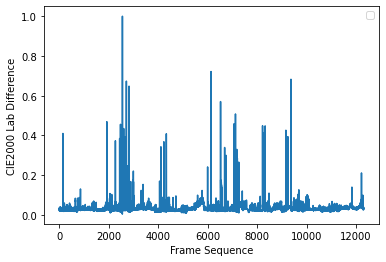

In [6]:
from skimage.color import deltaE_cie76
from skimage.color import deltaE_ciede94
from skimage.color import deltaE_ciede2000
from skimage.color import deltaE_cmc
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER WITH only MEAN as feature
#NAD58 
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE76(Lab_1, Lab_2):
   L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
   L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]

   dE_00 = math.sqrt(((L1-L2)^2) + ((a1-a2)^2) + ((b1-b2)^2))
   return dE_00

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12306):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

  L1m = np.std(L1)
  a1m = np.std(a1)
  b1m = np.std(b1)

  L2m = np.std(L2)
  a2m = np.std(a2)
  b2m = np.std(b2)

  
#print(np.mean(L1))
#print(a1)
  
  #diff = np.sqrt((L1m - L2m)**2 + (a1m - a2m)**2 + (b1m - b2m)**2 )
  #diff = deltaE_cie76(Lab11, Lab22)
  diff = deltaE_ciede2000(Lab1, Lab2)
  #diff = deltaE_cmc(Lab1, Lab2)
  diff = np.sum(diff)
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+1)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

#F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

#print("F1 Score")
#print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




Streaming output truncated to the last 5000 lines.
(60, 80, 3)
11025
11026
1.0089895537405302
(60, 80, 3)
11026
11027
0.9078091091579861
(60, 80, 3)
11027
11028
1.0122172037760417
(60, 80, 3)
11028
11029
1.4230737551294192
(60, 80, 3)
11029
11030
1.3746019767992423
(60, 80, 3)
11030
11031
0.8386057844065656
(60, 80, 3)
11031
11032
0.9034602617976641
(60, 80, 3)
11032
11033
0.896856812756471
(60, 80, 3)
11033
11034
0.7987329964685922
(60, 80, 3)
11034
11035
0.7127066564078283
(60, 80, 3)
11035
11036
0.6079640398121844
(60, 80, 3)
11036
11037
0.5098724365234375
(60, 80, 3)
11037
11038
0.5597211741437815
(60, 80, 3)
11038
11039
0.4593961465238321
(60, 80, 3)
11039
11040
0.5309532704979483
(60, 80, 3)
11040
11041
0.5593346798058713
(60, 80, 3)
11041
11042
0.4010748352667298
(60, 80, 3)
11042
11043
0.3802865076546717
(60, 80, 3)
11043
11044
0.46594657512626264
(60, 80, 3)
11044
11045
0.5022995457504735
(60, 80, 3)
11045
11046
0.41201578776041664
(60, 80, 3)
11046
11047
0.4453345712989268
(6

(60, 80, 3)
12275
12276
1.1180045079703282
(60, 80, 3)
12276
12277
1.1448160807291667
(60, 80, 3)
12277
12278
1.402868775647096
(60, 80, 3)
12278
12279
1.3296243686868687
(60, 80, 3)
12279
12280
1.032229768386995
(60, 80, 3)
12280
12281
0.9544093893031881
(60, 80, 3)
12281
12282
0.6219522495462437
(60, 80, 3)
12282
12283
0.6096200037484217
(60, 80, 3)
12283
12284
0.6001520946772412
(60, 80, 3)
12284
12285
0.5392510308159723
(60, 80, 3)
12285
12286
0.7558761442550505
(60, 80, 3)
12286
12287
0.699283114346591
(60, 80, 3)
12287
12288
0.5764654602667298
(60, 80, 3)
12288
12289
0.643521272293245
(60, 80, 3)
12289
12290
0.5691980843592171
(60, 80, 3)
12290
12291
0.6188514170020518
(60, 80, 3)
12291
12292
0.7187778665561869
(60, 80, 3)
12292
12293
0.6388696535669192
(60, 80, 3)
12293
12294
0.6097889293323864
(60, 80, 3)
12294
12295
0.6234005706478851
(60, 80, 3)
12295
12296
0.6671965011442551
(60, 80, 3)
12296
12297
0.574984587081755
(60, 80, 3)
12297
12298
0.7782908430003157
(60, 80, 3)
1229

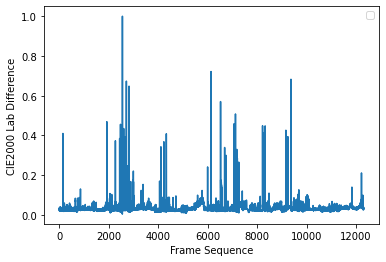

In [8]:
from skimage.color import deltaE_cie76
from skimage.color import deltaE_ciede94
from skimage.color import deltaE_ciede2000
from skimage.color import deltaE_cmc
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER WITH only MEAN as feature
#NAD58 threshold with Bendrau et al.
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE76(Lab_1, Lab_2):
   L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
   L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]

   dE_00 = math.sqrt(((L1-L2)^2) + ((a1-a2)^2) + ((b1-b2)^2))
   return dE_00

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12306):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

  L1m = np.std(L1)
  a1m = np.std(a1)
  b1m = np.std(b1)

  L2m = np.std(L2)
  a2m = np.std(a2)
  b2m = np.std(b2)

  
#print(np.mean(L1))
#print(a1)
  
  #diff = np.sqrt((L1m - L2m)**2 + (a1m - a2m)**2 + (b1m - b2m)**2 )
  #diff = deltaE_cie76(Lab11, Lab22)
  diff = deltaE_ciede2000(Lab1, Lab2)
  #diff = deltaE_cmc(Lab1, Lab2)
  diff = np.sum(diff)
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
alpha = 2.081
cont = np.array(labdiff)
cont = cont/max(cont)

newx = np.mean(cont)
sig = np.std(cont)

T = newx + alpha * sig

ab_cut = []
#deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(cont[i] > T):
    ab_cut.append(i+1)#+139)
   
print(len(ab_cut))
#print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

#F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

#print("F1 Score")
#print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




In [10]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER WITH only MEAN as feature
#NAD58 threshold madhusudan et.al

from skimage.color import deltaE_cie76
from skimage.color import deltaE_ciede94
from skimage.color import deltaE_ciede2000
from skimage.color import deltaE_cmc
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE76(Lab_1, Lab_2):
   L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
   L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]

   dE_00 = math.sqrt(((L1-L2)^2) + ((a1-a2)^2) + ((b1-b2)^2))
   return dE_00

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12306):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

  L1m = np.std(L1)
  a1m = np.std(a1)
  b1m = np.std(b1)

  L2m = np.std(L2)
  a2m = np.std(a2)
  b2m = np.std(b2)

  
#print(np.mean(L1))
#print(a1)
  
  #diff = np.sqrt((L1m - L2m)**2 + (a1m - a2m)**2 + (b1m - b2m)**2 )
  #diff = deltaE_cie76(Lab11, Lab22)
  diff = deltaE_ciede2000(Lab1, Lab2)
  #diff = deltaE_cmc(Lab1, Lab2)
  diff = np.mean(diff)
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  #print(diff/(60*88*3))
  print(diff)
  frame.append(k)
  #labdiff.append(diff/(60*88*3))
  labdiff.append(diff)
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
#labdiff = np.array(labdiff)#*(240*352*3)
#labdiff = labdiff/max(labdiff)
#print(max(labdiff))
#print(labdiff)
#plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
#plt.xlabel("Frame Sequence")
#plt.ylabel("CIE2000 Lab Difference")
#plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

cont = np.array(labdiff)
ab_cut = []
mn_average = np.mean(labdiff)
dev = np.std(labdiff)
T = (2*dev) + mn_average
for i in range(0,len(frame)):
  if(cont[i] > T):
    ab_cut.append(i+1)#+139)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

#F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

#print("F1 Score")
#print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




Streaming output truncated to the last 5000 lines.
(60, 80, 3)
11063
11064
1.6400313
(60, 80, 3)
11064
11065
1.4521458
(60, 80, 3)
11065
11066
1.3448188
(60, 80, 3)
11066
11067
1.3337659
(60, 80, 3)
11067
11068
1.3683221
(60, 80, 3)
11068
11069
1.4068742
(60, 80, 3)
11069
11070
1.4236172
(60, 80, 3)
11070
11071
1.3828545
(60, 80, 3)
11071
11072
1.4095056
(60, 80, 3)
11072
11073
1.5813657
(60, 80, 3)
11073
11074
1.2788491
(60, 80, 3)
11074
11075
1.5644867
(60, 80, 3)
11075
11076
1.2855469
(60, 80, 3)
11076
11077
1.4235258
(60, 80, 3)
11077
11078
1.7252551
(60, 80, 3)
11078
11079
1.9647111
(60, 80, 3)
11079
11080
1.607297
(60, 80, 3)
11080
11081
1.5099591
(60, 80, 3)
11081
11082
1.349155
(60, 80, 3)
11082
11083
1.6117257
(60, 80, 3)
11083
11084
1.2076925
(60, 80, 3)
11084
11085
1.3609862
(60, 80, 3)
11085
11086
1.5718954
(60, 80, 3)
11086
11087
1.5316966
(60, 80, 3)
11087
11088
1.4083529
(60, 80, 3)
11088
11089
1.8097945
(60, 80, 3)
11089
11090
1.4802986
(60, 80, 3)
11090
11091
1.3085189

In [ ]:
ab_cut = []
deli = 0.121
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+1)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

#F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

#print("F1 Score")
#print(F1)






29
[807, 854, 857, 1922, 2269, 2475, 2713, 2764, 2772, 2820, 3388, 3613, 3682, 4109, 4228, 5592, 5997, 6135, 6520, 7063, 7141, 8218, 8291, 8323, 9161, 9242, 9366, 11832, 12217]
[  807   854   857  1922  2269  2475  2713  2764  2772  2820  3388  3613
  3682  4109  4228  5592  5997  6135  6520  7063  7141  8218  8291  8323
  9161  9242  9366 11832 12217]
['147', '1922', '2269', '2441', '2475', '2493', '2553', '2605', '2659', '2713', '2764', '2820', '2887', '4056', '4109', '4228', '4328', '4716', '5997', '6135', '6520', '6685', '6747', '7063', '7123', '7141', '7159', '7178', '7198', '7219', '7239', '7256', '8218', '8291', '8323', '9161', '9242', '9366']
38
147
[147, 1922, 2269, 2441, 2475, 2493, 2553, 2605, 2659, 2713, 2764, 2820, 2887, 4056, 4109, 4228, 4328, 4716, 5997, 6135, 6520, 6685, 6747, 7063, 7123, 7141, 7159, 7178, 7198, 7219, 7239, 7256, 8218, 8291, 8323, 9161, 9242, 9366]
RECALL
0.6666666666666666
PRECISION
0.7916666666666666


In [ ]:
k = 100
image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
image1 = np.float32(image1)
image1 *= 1./255
image2 = np.float32(image2)
image2 *= 1./255

Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
print(Lab1.shape)
Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


L1, a1, b1 = cv2.split(Lab1)
L2, a2, b2 = cv2.split(Lab2)

L1m = np.mean(L1)
a1m = np.mean(a1)
b1m = np.mean(b1)

L2m = np.mean(L2)
a2m = np.mean(a2)
b2m = np.mean(b2)

L1 = L1/L1m
a1 = a1/a1m
b1 = b1/b1m
Lab11 = cv2.merge( (L1, a1, b1) )
Lab11

(60, 80, 3)


array([[[ 3.4768993e-01, -1.7829225e+00,  6.7857873e-01],
        [ 3.5451287e-01, -1.7829225e+00,  6.7565382e-01],
        [ 2.5665498e-01, -1.7667141e+00,  9.8276919e-01],
        ...,
        [ 1.9225757e-01,  1.3290876e+00,  5.1478386e-01],
        [ 3.2394978e-01,  2.1232986e+00,  5.8498168e-03],
        [ 2.7104858e-03,  8.1041932e-01,  5.2648351e-02]],

       [[ 3.4768993e-01, -1.7829225e+00,  6.7857873e-01],
        [ 3.4086695e-01, -1.7991309e+00,  6.8150365e-01],
        [ 3.2768840e-01, -1.7180890e+00,  9.5059520e-01],
        ...,
        [ 2.5815040e-01,  1.2642541e+00,  4.9723443e-01],
        [ 3.0890194e-01,  1.6370471e+00,  2.4276739e-01],
        [ 8.0379928e-03,  1.2156290e+00, -2.9249084e-03]],

       [[ 3.5787761e-01, -6.4833546e-01,  6.1423075e-01],
        [ 3.4423169e-01, -6.4833546e-01,  6.1715567e-01],
        [ 3.6899993e-01, -1.7180890e+00,  9.3304574e-01],
        ...,
        [ 3.1497714e-01,  1.2156290e+00,  4.7968498e-01],
        [ 3.3684796e-01,  1.6